In [2]:
import pandas as pd

import numpy as np
import scipy as sp
from scipy import signal
from scipy import ndimage
from scipy.ndimage.morphology import binary_closing
from scipy.optimize import curve_fit
from scipy.misc import imsave
import scipy.io as sio

import cv2
from PIL import ImageFilter
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops, label, find_contours
from skimage.restoration import unwrap_phase
from skimage.feature import blob_log, canny
from skimage.exposure import equalize_hist

import imageio
import random
import os
import fnmatch
import math
import re

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
image_path = "I:\\Honours-Project\\data\\test data\\simulation\\gestalt-theory-wwf-panda-logo.jpg"

In [4]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

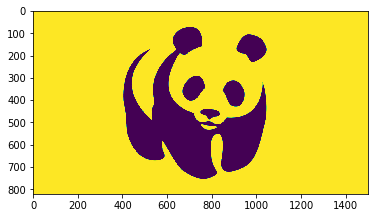

In [5]:
plt.imshow(gray)

In [6]:
def intensity(img):
    return np.real(img)**2 + np.imag(img)**2

In [7]:
def get_kernel(wavelength,z,dx,dy,x,y):
    kernelFactor = 2*math.pi*z/wavelength
    
    dfx = 1/(dx*x)
    dfy = 1/(dy*y)
    
    # Count up then down eg: [0,1,2,1,0]
    if x % 2 == 0:
        x2 = np.append(np.arange(x/2),np.flip(np.arange(x/2)))
    else:
        x2 = np.append(np.arange((x/2)-1),[math.ceil(x/2)])
        x2 = np.append(x2,np.flip(np.arange((x/2)-1)))
        
    if y % 2 == 0:
        y2 = np.append(np.arange(y/2),np.flip(np.arange(y/2)))
    else:
        y2 = np.append(np.arange((y/2)-1),[math.ceil(y/2)])
        y2 = np.append(y2,np.flip(np.arange((y/2)-1)))
    
    l = x2 - (x/2) + 1
    l2 = (l**2) * (dfx**2)
    
    m = y2 - (y/2) + 1
    m2 = (m**2) * (dfy**2) + 1
    
    l3 = np.broadcast_to(l2, (y,x)).transpose()
    m3 = np.broadcast_to(m2, (x,y))
    
    kernelPhase = np.power(1 - ((l3+m3) * (wavelength**2)),(1/2)) * kernelFactor
    
    real = np.cos(kernelPhase)
    img = 1j*np.sin(kernelPhase)
    
    return real+img

In [8]:
get_kernel(0.635,0,4.24,4.24,100,50)

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]])

In [9]:
'''
    img - complex array
    
'''

def angular_spectrum(img,wavelength,z,dx,dy):
    x,y = img.shape

    kernel = get_kernel(wavelength,z,dx,dy,x,y)
    
    fft = np.fft.fftshift(np.fft.fft2(img))
    inv = np.fft.ifft2(np.fft.fftshift(np.multiply(fft,kernel)))

    return inv

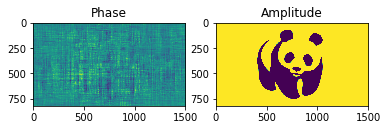

In [10]:
img = gray

wavelength=0.6328
z=0
dx=4.24
dy=4.24

a_s = angular_spectrum(img,wavelength,z,dx,dy)

real = np.real(a_s)
imaginary = np.imag(a_s)

fig,ax = plt.subplots(1,2)

ax[0].set_title("Phase")
ax[0].imshow(imaginary)

ax[1].set_title("Amplitude")
ax[1].imshow(real)

image_path = "I:\\Honours-Project\\data\\test data\\simulation\\phase_comp.jpg"
img = cv2.imread(image_path)
true_phase = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#print(true_phase/255)
#print(imaginary)
#print(true_phase == imaginary)

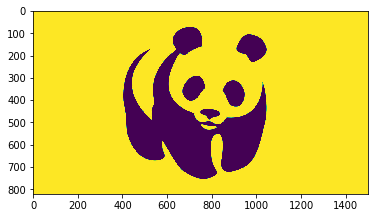

In [11]:
plt.imshow(intensity(a_s))

In [40]:
'''
    img - intensity image
    wavelength - nm
    z - um
    dx - um
    dy - um
'''

def object_propogation(img,wavelength,z,dx,dy):
    return angular_spectrum(img,wavelength,z,dx,dy)

In [50]:
'''
    wavelength - um
    dx - um
    dy - um
    a - degree 
    b - degree
    x - width of output in px
    y - height of output in px
'''
def gen_plane_wave(wavelength,dx,dy,a,b,x,y):
    alpha=math.cos(a/180*math.pi)
    beta=math.cos(b/180*math.pi)
    
    if not (1-(alpha**2)-(beta**2) > 0):
        print(alpha**2)
        print(1-(alpha**2)-(beta**2))
        raise ValueError("Insert a valid pair of director angles. Remember that cos^2(a) + cos^2(b) <= 1")
    
    gamma=math.sqrt(1-(alpha**2)-(beta**2))
    
    # wavelength=wavelength*0.001 # Convert wavelength to um
    
    k3 = 3*2*math.pi/wavelength #TODO: Currently assuming lambda is wavelength
    
    if k3 * alpha * dx > (2*math.pi):
        angle = math.degress(math.acos((2*math.pi) / (k3 * dx)))
        
        raise ValueError("In order to fulfill the sampling theorem, the director angle a >= " + str(df.format(angle)))
    
    if k3 * beta * dx > (2*math.pi):
        angle = math.degress(math.acos((2*math.pi) / (k3 * dy)))
        
        raise ValueError("In order to fulfill the sampling theorem, the director angle b >= " + str(df.format(angle)))
        
    k = 2 * math.pi / wavelength
    
    n = k * gamma
    
    l = (np.arange(x) - (x/2) + 1) * dx * alpha * k
    m = (np.arange(y) - (y/2) + 1) * dy * beta * k
    
    l = np.broadcast_to(l, (y,x)).transpose()
    m = np.broadcast_to(m, (x,y))
    n = np.broadcast_to(n, (x,y))
    
    phase = l + m + n
    
    wavefront_real = np.cos(phase)
    wavefront_imaginary = np.sin(phase)
    
    return wavefront_real, wavefront_imaginary

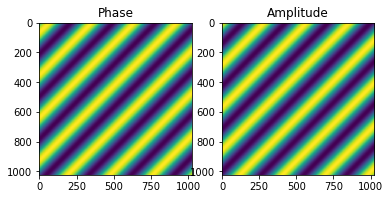

In [51]:
real, imaginary = gen_plane_wave(0.6328,0.424,0.424,89.7,89.7,1024,1024)

fig,ax = plt.subplots(1,2)

ax[0].set_title("Phase")
ax[0].imshow(imaginary)

ax[1].set_title("Amplitude")
ax[1].imshow(real)

In [ ]:
def generate_noise():
    

## Generate Sample

In [59]:
wavelength=0.6328 # - um
z=0
dx=4.24 # - um
dy=4.24 # - um

a=87.81 # deg
b=87.81 # deg

In [53]:
image_path = "I:\\Honours-Project\\data\\test data\\simulation\\gestalt-theory-wwf-panda-logo.jpg"

In [54]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = (gray-np.min(gray))/(np.max(gray)-np.min(gray))

x,y = gray.shape

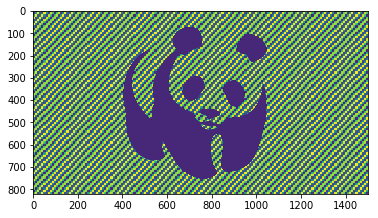

In [60]:
real, imaginary = gen_plane_wave(wavelength,dx,dy,a,b,x,y)

plane_wave = real + 1j*imaginary

obj = intensity(gray+(1j*gray))

object_wave = object_propogation(obj,wavelength,z,dx,dy)

comb_wave = plane_wave + object_wave

inten = intensity(comb_wave)

plt.imshow(inten)
np.save('panda_hologram',inten)
imageio.imwrite('panda_hologram.jpg',inten)